We want to compare the average occupancy rate of the proposed DMBAR system and a rigid system that uses fixed capacity buses just like the conventional transit system.

*NB:* "UNCHANGED" refers to the code in "final dmbar" so please check it first before reading this.

--- Starting DMBAR PPO Training for 20 epochs (Action Dim: 61)---


/tmp/ipython-input-1824553081.py:620: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states_t = torch.tensor([t.state for t in transitions], dtype=torch.float32, device=device)


Epoch 1/20: Avg. Cost/Req=552.42, Reject Rate=0.386
Epoch 2/20: Avg. Cost/Req=527.29, Reject Rate=0.373
Epoch 3/20: Avg. Cost/Req=512.18, Reject Rate=0.359
Epoch 4/20: Avg. Cost/Req=522.84, Reject Rate=0.368
Epoch 5/20: Avg. Cost/Req=544.02, Reject Rate=0.390
Epoch 6/20: Avg. Cost/Req=543.83, Reject Rate=0.384
Epoch 7/20: Avg. Cost/Req=528.88, Reject Rate=0.374
Epoch 8/20: Avg. Cost/Req=482.05, Reject Rate=0.349
Epoch 9/20: Avg. Cost/Req=471.45, Reject Rate=0.328
Epoch 10/20: Avg. Cost/Req=513.78, Reject Rate=0.365
Epoch 11/20: Avg. Cost/Req=500.95, Reject Rate=0.354
Epoch 12/20: Avg. Cost/Req=496.90, Reject Rate=0.345
Epoch 13/20: Avg. Cost/Req=480.51, Reject Rate=0.340
Epoch 14/20: Avg. Cost/Req=499.24, Reject Rate=0.345
Epoch 15/20: Avg. Cost/Req=474.17, Reject Rate=0.343
Epoch 16/20: Avg. Cost/Req=479.12, Reject Rate=0.342
Epoch 17/20: Avg. Cost/Req=522.40, Reject Rate=0.373
Epoch 18/20: Avg. Cost/Req=476.79, Reject Rate=0.343
Epoch 19/20: Avg. Cost/Req=494.40, Reject Rate=0.351
Ep

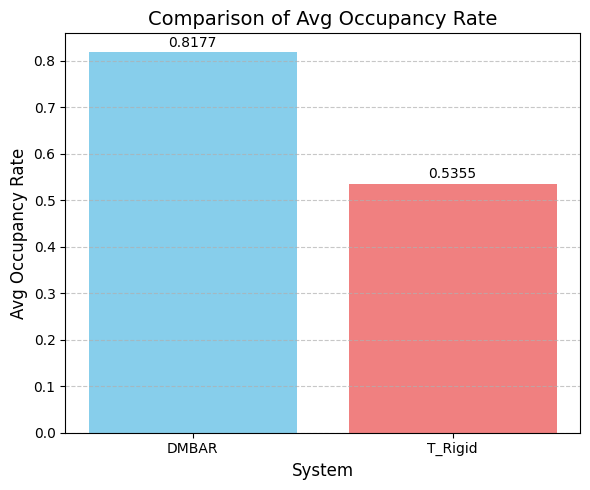

In [1]:
import random
import math
import time as pytime
from collections import namedtuple
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from copy import deepcopy # Important for vehicle assignment in the heuristic

# -------------------------
# Utility Classes: Vehicle, Request, DirectedNetwork (UNCHANGED)
# -------------------------
class Vehicle:
    def __init__(self, vid, tavail=0.0, pavail=0, m=0, config=None):
        self.vid = vid
        self.tavail = tavail
        self.pavail = pavail
        self.m = m
        self.config = [] if config is None else config

    def copy(self):
        return Vehicle(self.vid, self.tavail, self.pavail, self.m, list(self.config))

class Request:
    def __init__(self, origin, dest, te, tl, n, route=None):
        self.or_ = origin
        self.dr = dest
        self.te = te
        self.tl = tl
        self.n = n
        self.Pr = route
        self.t_pickup_actual = None
        self.t_wait = None
        self.t_ride = None

class DirectedNetwork:
    def __init__(self, n_nodes=10, seed=0):
        self.n = n_nodes
        random.seed(seed)
        np.random.seed(seed)
        self.G = nx.DiGraph()
        for i in range(n_nodes):
            self.G.add_node(i)
        for i in range(n_nodes):
            self.G.add_edge(i, (i+1) % n_nodes, weight=1.0)
        for _ in range(max(1, n_nodes // 2) * n_nodes):
            a, b = random.randrange(n_nodes), random.randrange(n_nodes)
            if a != b and not self.G.has_edge(a, b):
                self.G.add_edge(a, b, weight=random.uniform(0.5, 2.0))
    def travel_time(self, a, b):
        try:
            return nx.shortest_path_length(self.G, a, b, weight='weight')
        except nx.NetworkXNoPath:
            return float('inf')

# -------------------------
# DMBAR Environment (Your Original System)
# -------------------------
class DMBAREnv:
    def __init__(self, network, depots, num_modules=5, Cm=5, seed=0):
        self.net = network
        self.depots = depots
        self.num_modules = num_modules
        self.Cm = Cm
        self.max_time = 10000.0
        self.max_request_n = 25
        self.max_vehicle_slots = 20
        self.num_initial_vehicles = 10
        self.total_initial_modules = 20
        self.crej = 100.0
        self.cop = 1.0
        self.cwait = 0.3
        self.creconf = 1.0
        self.cmerge = 0.5
        self.split_time = 0.5
        self.merge_time = 0.5

        # Action Space for DMBAR
        self.ACTIONS_PER_VEHICLE = 3  # (0: Direct, 1: Split, 2: Merge)
        self.GLOBAL_ACTIONS = 1      # (Single Global Reject)
        self.ACTION_DIM = (self.ACTIONS_PER_VEHICLE * self.max_vehicle_slots) + self.GLOBAL_ACTIONS # 61 total actions
        self.GLOBAL_REJECT_INDEX = self.ACTION_DIM - 1 # Index 60

        random.seed(seed)
        np.random.seed(seed)
        self.seed = seed

        # self.requests is set during reset
        self.requests = []
        self.req_index = 0
        self.time = 0.0

    def reset(self, request_stream=None):
        """Resets the environment, optionally using a predefined request stream."""
        random.seed(self.seed)
        np.random.seed(self.seed)
        self.time = 0.0
        self.vehicles = []
        self.next_module_id = 0
        all_module_ids = list(range(self.total_initial_modules))
        random.shuffle(all_module_ids)
        vehicle_configs = [[] for _ in range(self.num_initial_vehicles)]
        v_index = 0

        for module_id in all_module_ids:
            while len(vehicle_configs[v_index % self.num_initial_vehicles]) >= self.num_modules:
                v_index += 1
            vehicle_configs[v_index % self.num_initial_vehicles].append(module_id)
            v_index += 1

        for i in range(self.num_initial_vehicles):
            config = vehicle_configs[i]
            depot_index = i % len(self.depots)
            v = Vehicle(vid=i, tavail=0.0, pavail=self.depots[depot_index], m=len(config), config=config)
            self.vehicles.append(v)

        for i in range(self.num_initial_vehicles, self.max_vehicle_slots):
            self.vehicles.append(Vehicle(vid=i, tavail=0.0, pavail=self.depots[0], m=0, config=[]))
        self.next_module_id = self.total_initial_modules

        if request_stream is None:
            # Fallback for training: generate a fresh stream
            self._build_request_stream(length=500)
        else:
            # Use the provided stream for consistent testing
            self.requests = request_stream

        self.req_index = 0
        obs, mask = self._get_obs_and_mask()
        return obs, mask

    def _build_request_stream(self, length=500):
        seq = []
        t = 0.0
        for _ in range(length):
            t += max(0.1, np.random.exponential(1.0))
            if t > self.max_time: break
            o, d = random.randrange(self.net.n), random.randrange(self.net.n)
            while d == o: d = random.randrange(self.net.n)
            n = random.randint(1, self.max_request_n)
            te = t
            tl = t + random.uniform(2.0, 10.0)
            seq.append(Request(o, d, te, tl, n))
        self.requests = seq

    def _current_request(self):
        return self.requests[self.req_index] if self.req_index < len(self.requests) else None

    def _state_dim(self):
        vfeat = 1 + self.net.n + 1
        rfeat = self.net.n * 2 + 3
        return self.max_vehicle_slots * vfeat + rfeat

    def _encode_state(self, req=None):
        vec = []
        for v in self.vehicles:
            vec.append((v.tavail - self.time) / (self.max_time + 1e-6))
            onehot = [0.0] * self.net.n
            onehot[v.pavail] = 1.0
            vec.extend(onehot)
            vec.append(v.m / self.num_modules)

        if req is None:
            vec.extend([0.0] * (self.net.n*2 + 3))
        else:
            or_oh, dr_oh = [0.0]*self.net.n, [0.0]*self.net.n
            or_oh[req.or_], dr_oh[req.dr] = 1.0, 1.0
            vec.extend(or_oh + dr_oh)
            vec.append(req.n / (self.Cm * self.num_modules))
            vec.append((req.te - self.time)/(self.max_time + 1e-6))
            vec.append((req.tl - self.time)/(self.max_time + 1e-6))
        return np.array(vec, dtype=np.float32)

    def _get_obs_and_mask(self):
        req = self._current_request()
        return self._encode_state(req), self.compute_mask(req)

    def compute_mask(self, req):
        nA = self.ACTION_DIM
        mask = np.zeros(nA, dtype=np.float32)
        mask[self.GLOBAL_REJECT_INDEX] = 1.0

        if req is None: return mask

        needed = math.ceil(req.n / self.Cm)
        has_inactive_slot = any(v.m == 0 for v in self.vehicles)
        t_start_reposition = max(self.time, 0.0)

        for i, v in enumerate(self.vehicles):
            base_idx = self.ACTIONS_PER_VEHICLE * i

            # Action 0: assign_direct
            t_to_origin = self.net.travel_time(v.pavail, req.or_)
            t_ride = self.net.travel_time(req.or_, req.dr)
            t_start_direct = max(v.tavail, t_start_reposition)
            t_pickup_direct = t_start_direct + t_to_origin
            t_arrival_direct = t_pickup_direct + t_ride # Added for strict TL check
            is_direct_time_feasible = (t_arrival_direct <= req.tl) # Strict TL check

            if v.m >= needed and is_direct_time_feasible:
                mask[base_idx + 0] = 1.0

            # Action 1: split_assign
            t_split_finish = max(v.tavail, t_start_reposition) + self.split_time
            t_pickup_split = t_split_finish + t_to_origin
            t_arrival_split = t_pickup_split + t_ride # Added for strict TL check
            is_split_time_feasible = (t_arrival_split <= req.tl) # Strict TL check
            if v.m > needed and has_inactive_slot and is_split_time_feasible:
                mask[base_idx + 1] = 1.0

            # Action 2: merge_assign
            if v.m > 0 and v.m < needed:
                can_find_feasible_partner = False
                t_arrival_v_at_origin = max(v.tavail, t_start_reposition) + t_to_origin

                for j, v_other in enumerate(self.vehicles):
                    if i != j and v_other.m > 0 and (v.m + v_other.m >= needed):
                        t_to_origin_other = self.net.travel_time(v_other.pavail, req.or_)
                        t_arrival_other_at_origin = max(v_other.tavail, t_start_reposition) + t_to_origin_other
                        t_merge_start = max(t_arrival_v_at_origin, t_arrival_other_at_origin)
                        t_pickup_merge = t_merge_start + self.merge_time
                        t_ride = self.net.travel_time(req.or_, req.dr) # Recalculate t_ride inside
                        t_arrival_merge = t_pickup_merge + t_ride # Added for strict TL check
                        if t_arrival_merge <= req.tl: # Strict TL check
                            can_find_feasible_partner = True
                            break
                if can_find_feasible_partner:
                    mask[base_idx + 2] = 1.0

        return mask

    def step(self, action):
        info = {}
        req = self._current_request()
        if req is None:
            obs = self._encode_state(None)
            return obs, self.compute_mask(None), 0.0, True, info

        served = True
        cost = 0.0
        needed = math.ceil(req.n / self.Cm)
        self.time = max(self.time, req.te)
        t_start_reposition = self.time
        t_pickup, t_ride = 0.0, 0.0
        v = None

        if action == self.GLOBAL_REJECT_INDEX:
            a_type = 3
            i = -1
        else:
            i = action // self.ACTIONS_PER_VEHICLE
            a_type = action % self.ACTIONS_PER_VEHICLE
            v = self.vehicles[i]

        if a_type == 0:  # assign_direct
            # Capacity check based on total request size vs. fixed bus size
            if req.n > (v.m * self.Cm): # Added runtime check for DMBAR
                cost, served = self.crej * req.n, False
                info['action_type'] = 'reject_capacity'
            else:
                t_to_origin = self.net.travel_time(v.pavail, req.or_)
                t_ride = self.net.travel_time(req.or_, req.dr)
                t_start_direct = max(v.tavail, t_start_reposition)
                t_pickup = t_start_direct + t_to_origin
                t_arrival = t_pickup + t_ride

                # CRITICAL: Re-check time feasibility AFTER calculating full path
                if t_arrival > req.tl:
                    cost, served = self.crej * req.n, False
                    info['action_type'] = 'reject_time_violation'
                else:
                    cost = self.cop * (t_to_origin + t_ride)
                    v.tavail = t_arrival
                    v.pavail = req.dr
                    info['action_type'] = 'direct'

        elif a_type == 1:  # split_assign
            v_child = next((slot for slot in self.vehicles if slot.m == 0), None)
            if v_child is None: cost, a_type, served = self.crej * req.n, 3, False; info['action_type'] = 'reject_no_slot'
            elif req.n > ((v.m - needed) * self.Cm) or req.n > (needed * self.Cm): # Capacity check after split
                cost, served = self.crej * req.n, False
                info['action_type'] = 'reject_capacity_split'
            else:
                t_to_origin = self.net.travel_time(v.pavail, req.or_)
                t_ride = self.net.travel_time(req.or_, req.dr)
                t_split_finish = max(v.tavail, t_start_reposition) + self.split_time
                t_pickup = t_split_finish + t_to_origin
                t_arrival = t_pickup + t_ride

                if t_arrival > req.tl: # Re-check time feasibility
                    cost, served = self.crej * req.n, False
                    info['action_type'] = 'reject_time_violation_split'
                else:
                    cost = self.creconf + self.cop * (t_to_origin + t_ride)
                    child_config = v.config[:needed]
                    parent_config = v.config[needed:]
                    v.m, v.config, v.tavail = len(parent_config), parent_config, t_split_finish
                    v_child.m, v_child.config, v_child.pavail, v_child.tavail = len(child_config), child_config, req.dr, t_arrival
                    info['action_type'] = 'split'

        elif a_type == 2:  # merge_assign
            best_partner = None
            min_merge_start_time = float('inf')
            t_to_origin_v = self.net.travel_time(v.pavail, req.or_)
            t_arrival_v = max(v.tavail, t_start_reposition) + t_to_origin_v
            best_partner_to_origin_travel = 0.0

            for v_other in self.vehicles:
                if v_other.vid == v.vid or v_other.m == 0: continue
                if (v.m + v_other.m) * self.Cm >= req.n: # Capacity check for merged vehicle
                    t_to_origin_other = self.net.travel_time(v_other.pavail, req.or_)
                    t_arrival_other = max(v_other.tavail, t_start_reposition) + t_to_origin_other
                    t_merge_start = max(t_arrival_v, t_arrival_other)
                    t_pickup_merge = t_merge_start + self.merge_time
                    t_ride = self.net.travel_time(req.or_, req.dr)
                    t_arrival = t_pickup_merge + t_ride

                    if t_arrival <= req.tl: # Time feasibility check for merged vehicle
                        if t_merge_start < min_merge_start_time:
                            min_merge_start_time, best_partner, best_partner_to_origin_travel = t_merge_start, v_other, t_to_origin_other

            if best_partner is None:
                cost, a_type, served = self.crej * req.n, 3, False; info['action_type'] = 'reject_no_merge_partner'
            else:
                v_other = best_partner
                t_merge_start = min_merge_start_time
                t_pickup = t_merge_start + self.merge_time
                t_ride = self.net.travel_time(req.or_, req.dr)
                t_arrival = t_pickup + t_ride # Recalculate t_arrival for merged vehicle

                if t_arrival > req.tl: # Final check
                    cost, served = self.crej * req.n, False
                    info['action_type'] = 'reject_time_violation_merge'
                else:
                    op_cost_v = self.cop * t_to_origin_v
                    op_cost_other = self.cop * best_partner_to_origin_travel
                    op_cost_ride = self.cop * t_ride
                    cost = self.creconf + self.cmerge + op_cost_v + op_cost_other + op_cost_ride
                    v.config = v.config + v_other.config
                    v.m, v.tavail, v.pavail = v.m + v_other.m, t_arrival, req.dr
                    v_other.m, v_other.config, v_other.tavail, v_other.pavail = 0, [], t_merge_start, req.or_
                    info['action_type'] = 'merge'

        else:  # a_type == 3, Global Reject
            cost, served = self.crej * req.n, False
            info['action_type'] = 'reject'

        reward = -cost
        info['cost'] = cost

        if served:
            info['wait_time'] = max(0.0, t_pickup - req.te)
            info['vehicle_occupancy_rate'] = req.n / (needed * self.Cm)
        else:
            info['wait_time'] = 0.0
            info['vehicle_occupancy_rate'] = 0.0

        info['is_rejected'] = (not served)
        info['request_size'] = req.n
        info['request_module_needed'] = needed
        info['num_active_vehicles'] = sum(1 for vh in self.vehicles if vh.m > 0)
        info['total_modules_active'] = sum(vh.m for vh in self.vehicles)

        self.req_index += 1
        next_req = self._current_request()
        done = next_req is None
        obs, next_mask = self._encode_state(next_req), self.compute_mask(next_req)

        return obs, next_mask, reward, done, info

# ---------------------------------------------------
# NEW: T-Rigid Bus System (Fixed Capacity, On-Demand Assignment)
# ---------------------------------------------------
class T_RigidEnv(DMBAREnv):
    """
    T-Rigid Bus System Environment (Fixed Capacity, On-Demand Assignment).
    Inherits from DMBAREnv but overrides capacity and action space constraints.
    Uses max capacity of one DMBAR vehicle as the fixed capacity.
    """
    def __init__(self, network, depots, num_modules=5, Cm=5, seed=0):
        # The fixed capacity for one conventional bus
        self.max_bus_capacity = num_modules * Cm

        # Override action space for T-Rigid: Only Direct (0) and Global Reject
        self.ACTIONS_PER_VEHICLE = 1 # Only Direct Assignment
        self.GLOBAL_ACTIONS = 1
        self.ACTION_DIM = (self.ACTIONS_PER_VEHICLE * 20) + self.GLOBAL_ACTIONS # 21 total actions
        self.GLOBAL_REJECT_INDEX = self.ACTION_DIM - 1

        # Call parent init to set constants, but then override initial vehicle state
        super().__init__(network, depots, num_modules, Cm, seed)
        # Note: self.seed is set via super().__init__

    def reset(self, request_stream=None):
        """Resets the environment with fixed-capacity vehicles."""
        random.seed(self.seed)
        np.random.seed(self.seed)
        self.time = 0.0
        self.vehicles = []
        depot = self.depots[0]

        # All initial vehicles are max size and fixed for the Rigid system
        # For consistency with DMBAREnv, we set m=self.num_modules (max possible modules)
        for i in range(self.num_initial_vehicles):
            v = Vehicle(vid=i, tavail=0.0, pavail=depot, m=self.num_modules, config=[])
            self.vehicles.append(v)

        # Pad up to max_vehicle_slots with inactive vehicles (m=0) for consistent state size
        for i in range(self.num_initial_vehicles, self.max_vehicle_slots):
            self.vehicles.append(Vehicle(vid=i, tavail=0.0, pavail=depot, m=0, config=[]))

        if request_stream is None:
            self._build_request_stream(length=500)
        else:
            self.requests = request_stream

        self.req_index = 0
        obs = self._encode_state(self._current_request()) # State encoding is the same
        mask = self.compute_mask(self._current_request()) # Mask is unique to T-Rigid
        return obs, mask

    def compute_mask(self, req):
        """Only enables Direct Assignment for feasible vehicles and Global Reject."""
        nA = self.ACTION_DIM
        mask = np.zeros(nA, dtype=np.float32)
        mask[self.GLOBAL_REJECT_INDEX] = 1.0

        if req is None: return mask

        is_request_size_feasible = (req.n <= self.max_bus_capacity)
        t_start_reposition = max(self.time, 0.0)

        for i, v in enumerate(self.vehicles):
            base_idx = self.ACTIONS_PER_VEHICLE * i # Index i

            # Action 0: assign_direct
            if v.m > 0 and is_request_size_feasible:
                t_to_origin = self.net.travel_time(v.pavail, req.or_)
                t_ride = self.net.travel_time(req.or_, req.dr) # Needed for full arrival time check
                t_start_direct = max(v.tavail, t_start_reposition)
                t_pickup_direct = t_start_direct + t_to_origin
                t_arrival_direct = t_pickup_direct + t_ride # Full arrival time
                is_direct_time_feasible = (t_arrival_direct <= req.tl) # Strict TL check

                if is_direct_time_feasible:
                    mask[base_idx + 0] = 1.0

        return mask

    def step(self, action):
        """Executes only Direct Assignment or Reject actions for T-Rigid system."""
        info = {}
        req = self._current_request()
        if req is None:
            return self._encode_state(None), self.compute_mask(None), 0.0, True, info

        served = True
        cost = 0.0
        # In T-Rigid, 'needed' is just used for occupancy calculation: max capacity (num_modules)
        needed = self.num_modules
        self.time = max(self.time, req.te)
        t_start_reposition = self.time
        t_pickup, t_ride = 0.0, 0.0
        v = None

        if action == self.GLOBAL_REJECT_INDEX:
            a_type = 1 # Internal reject identifier
        else:
            i = action // self.ACTIONS_PER_VEHICLE
            a_type = action % self.ACTIONS_PER_VEHICLE # Must be 0 (Direct)
            v = self.vehicles[i]

        if a_type == 0:  # assign_direct
            # Capacity check based on total request size vs. fixed bus size
            if req.n > self.max_bus_capacity:
                cost, served = self.crej * req.n, False
                info['action_type'] = 'reject_capacity'
            else:
                t_to_origin = self.net.travel_time(v.pavail, req.or_)
                t_ride = self.net.travel_time(req.or_, req.dr)
                t_start_direct = max(v.tavail, t_start_reposition)
                t_pickup = t_start_direct + t_to_origin
                t_arrival = t_pickup + t_ride

                # CRITICAL: Re-check time feasibility AFTER calculating full path
                if t_arrival > req.tl:
                    cost, served = self.crej * req.n, False
                    info['action_type'] = 'reject_time_violation'
                else:
                    cost = self.cop * (t_to_origin + t_ride) # Operational cost includes repositioning
                    v.tavail = t_arrival
                    v.pavail = req.dr
                    info['action_type'] = 'direct'
        else:  # a_type == 1, Reject
            cost, served = self.crej * req.n, False
            info['action_type'] = 'reject'

        # KPI logging (Uses same logic as DMBAREnv)
        reward = -cost
        info['cost'] = cost
        if served:
            info['wait_time'] = max(0.0, t_pickup - req.te)
            info['vehicle_occupancy_rate'] = req.n / self.max_bus_capacity # Occupancy based on fixed max capacity
        else:
            info['wait_time'] = 0.0
            info['vehicle_occupancy_rate'] = 0.0

        info['is_rejected'] = (not served)
        info['request_size'] = req.n
        info['request_module_needed'] = needed # This is max_modules, not actual modules for req.n
        info['num_active_vehicles'] = sum(1 for vh in self.vehicles if vh.m > 0)
        info['total_modules_active'] = sum(vh.m for vh in self.vehicles) # Always sum(num_modules) for T-Rigid if all active

        self.req_index += 1
        next_req = self._current_request()
        done = next_req is None
        obs, next_mask = self._encode_state(next_req), self.compute_mask(next_req)

        return obs, next_mask, reward, done, info

# -------------------------
# PPO Model and Training Utilities (UNCHANGED)
# -------------------------
class MaskedCategorical(torch.distributions.Categorical):
    def __init__(self, logits, mask):
        very_neg = -1e9
        masked_logits = torch.where(mask > 0.5, logits, torch.full_like(logits, very_neg))
        super().__init__(logits=masked_logits)

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256):
        super().__init__()
        self.actor = nn.Sequential(nn.Linear(state_dim, hidden), nn.ReLU(),
                                   nn.Linear(hidden, hidden//2), nn.ReLU(),
                                   nn.Linear(hidden//2, action_dim))
        self.critic = nn.Sequential(nn.Linear(state_dim, hidden), nn.ReLU(),
                                   nn.Linear(hidden, hidden//2), nn.ReLU(),
                                   nn.Linear(hidden//2, 1))
    def forward(self, x):
        return self.actor(x), self.critic(x).squeeze(-1)

Transition = namedtuple('Transition', ['state','mask','action','logp','reward','value','done'])

def compute_gae(transitions, last_value, gamma=0.99, lam=0.95):
    rewards = [t.reward for t in transitions]
    values = [t.value for t in transitions]
    dones = [t.done for t in transitions]
    advs, gae = [], 0.0
    for i in reversed(range(len(rewards))):
        nxt = last_value if i == len(rewards)-1 else values[i+1]
        mask = 0.0 if dones[i] else 1.0
        delta = rewards[i] + gamma * nxt * mask - values[i]
        gae = delta + gamma * lam * mask * gae
        advs.insert(0, gae)
    returns = [advs[i] + values[i] for i in range(len(advs))]
    return advs, returns

def train(model_path="ppo_dmbar_model.pth"):
    net = DirectedNetwork(n_nodes=12, seed=1)
    depots = [0, 6]
    env = DMBAREnv(net, depots, num_modules=5, Cm=5, seed=1)

    state_dim = env._state_dim()
    action_dim = env.ACTION_DIM
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ActorCritic(state_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    epochs, steps_per_epoch = 20, 1024 # Reduced epochs for demonstration
    gamma, lam, clip_eps = 0.99, 0.95, 0.2
    ent_coef, value_coef = 0.05, 0.5
    max_grad_norm = 0.5

    log_data = []

    print(f"--- Starting DMBAR PPO Training for {epochs} epochs (Action Dim: {action_dim})---")
    for ep in range(epochs):
        transitions, steps, total_cost, total_rejects = [], 0, 0.0, 0

        # Generate a temporary stream for training purposes
        env._build_request_stream(length=steps_per_epoch)
        obs, mask = env.reset(env.requests)

        done = False

        while not done and steps < steps_per_epoch:
            s = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            mask_t = torch.tensor(mask, dtype=torch.float32, device=device).unsqueeze(0)

            with torch.no_grad():
                logits, value = model(s)
                dist = MaskedCategorical(logits=logits, mask=mask_t)
                a = dist.sample().item()
                logp = dist.log_prob(torch.tensor(a, device=device)).item()
                v = value.item()

            next_obs, next_mask, reward, done, info = env.step(a)

            transitions.append(Transition(obs, mask, a, logp, reward, v, done))
            obs, mask = next_obs, next_mask
            total_cost += -reward
            if info.get('is_rejected', False): total_rejects += 1
            steps += 1

        # PPO update logic
        if steps > 0:
            last_val = 0.0
            if not done:
                s = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                with torch.no_grad(): _, val = model(s); last_val = val.item()

            advs, returns = compute_gae(transitions, last_val, gamma, lam)

            # Convert to tensors
            states_t = torch.tensor([t.state for t in transitions], dtype=torch.float32, device=device)
            actions_t = torch.tensor([t.action for t in transitions], dtype=torch.long, device=device)
            logps_t = torch.tensor([t.logp for t in transitions], dtype=torch.float32, device=device)
            advs_t = torch.tensor(advs, dtype=torch.float32, device=device)
            returns_t = torch.tensor(returns, dtype=torch.float32, device=device)
            masks_t = torch.tensor([t.mask for t in transitions], dtype=torch.float32, device=device)

            # Normalize advantages
            advs_t = (advs_t - advs_t.mean()) / (advs_t.std() + 1e-8)

            # PPO epochs
            for _ in range(3): # typically 3-10
                new_logits, new_values = model(states_t)
                new_dist = MaskedCategorical(logits=new_logits, mask=masks_t)
                new_logps = new_dist.log_prob(actions_t)

                ratio = torch.exp(new_logps - logps_t)
                surr1 = ratio * advs_t
                surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * advs_t
                actor_loss = -torch.min(surr1, surr2).mean()

                critic_loss = value_coef * nn.MSELoss()(new_values, returns_t)
                entropy_loss = -ent_coef * new_dist.entropy().mean()

                loss = actor_loss + critic_loss + entropy_loss

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

            avg_cost = total_cost / steps
            reject_rate = total_rejects / steps

            log_data.append({'epoch': ep + 1, 'avg_cost': avg_cost, 'reject_rate': reject_rate})
            print(f"Epoch {ep+1}/{epochs}: Avg. Cost/Req={avg_cost:.2f}, Reject Rate={reject_rate:.3f}")

    torch.save(model.state_dict(), model_path)
    print(f"\n✅ Training finished. Model saved to '{model_path}'")
    return model

def load_model(model_path, state_dim, action_dim):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ActorCritic(state_dim, action_dim).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        print(f"Model loaded successfully from {model_path}.")
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Please train first.")
        return None
    except Exception as e:
        print(f"Error loading model: {e}. Model might be corrupt or incompatible.")
        return None
    return model

# ---------------------------------------------------
# Comparison and Simulation Logic
# ---------------------------------------------------

def generate_master_requests(env_template, length=1000, seed=1):
    """Generates a single, deterministic stream of requests for fair comparison."""
    random.seed(seed)
    np.random.seed(seed)

    seq = []
    t = 0.0
    for _ in range(length):
        t += max(0.1, np.random.exponential(1.0))
        if t > env_template.max_time: break
        o, d = random.randrange(env_template.net.n), random.randrange(env_template.net.n)
        while d == o: d = random.randrange(env_template.net.n)
        n = random.randint(1, env_template.max_request_n)
        te = t
        tl = t + random.uniform(2.0, 10.0)
        seq.append(Request(o, d, te, tl, n))
    return seq

def run_dmbar_agent(model, env, request_stream, seed):
    """Tests the DMBAR PPO agent using the shared request stream."""
    device = next(model.parameters()).device
    model.eval()
    test_log_data = []

    # Ensure environment is reset with the specific seed for request stream
    # and internal randomness
    env.seed = seed
    obs, mask = env.reset(request_stream=request_stream)
    done = False

    while not done:
        s = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        mask_t = torch.tensor(mask, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            logits, _ = model(s)
            dist = MaskedCategorical(logits=logits, mask=mask_t)
            a = dist.sample().item()

        current_req = env._current_request()
        next_obs, next_mask, reward, done, info = env.step(a)

        if current_req: # Only log if a request was actually processed
            test_log_data.append({
                'action_type': info['action_type'], 'cost': info['cost'],
                'is_rejected': info['is_rejected'],
                'wait_time': info['wait_time'],
                'request_size': info['request_size'],
                'occupancy_rate': info['vehicle_occupancy_rate'],
                'num_active_vehicles': info['num_active_vehicles'],
            })

        obs, mask = next_obs, next_mask

    return pd.DataFrame(test_log_data)


def run_trigid_heuristic(env, request_stream, seed):
    """
    Simulates the T-Rigid Bus System (Fixed Capacity, On-Demand Assignment).
    Policy: Assign to the available fixed-capacity bus that serves EARLIEST,
            subject to capacity and delivery deadline (tl) constraints.
    """
    env_sim = deepcopy(env)
    env_sim.seed = seed
    env_sim.reset(request_stream=request_stream)

    test_log_data = []

    req = env_sim._current_request()
    while req is not None:
        best_v, min_arrival_time, t_pickup = None, float('inf'), float('inf')
        needed = env_sim.num_modules # Used for internal capacity calc in heuristic, not directly for assign

        # Heuristic: Find the vehicle that can pick up and deliver the EARLIEST
        # while meeting capacity and time constraints.
        if req.n <= env_sim.max_bus_capacity:
            t_start_reposition = max(env_sim.time, req.te)

            for v in env_sim.vehicles:
                if v.m == 0: continue # Only consider active buses

                t_to_origin = env_sim.net.travel_time(v.pavail, req.or_)
                t_ride = env_sim.net.travel_time(req.or_, req.dr)
                t_start_direct = max(v.tavail, t_start_reposition)
                current_t_pickup = t_start_direct + t_to_origin
                current_t_arrival = current_t_pickup + t_ride

                if current_t_arrival <= req.tl:
                    if current_t_arrival < min_arrival_time:
                        min_arrival_time, best_v, t_pickup = current_t_arrival, v, current_t_pickup

        # Action execution
        served = (best_v is not None)
        cost, action_type, wait_time, occupancy_rate = 0.0, 'reject', 0.0, 0.0

        if served:
            t_arrival = min_arrival_time
            t_to_origin = env_sim.net.travel_time(best_v.pavail, req.or_) # Recalculate best_v's journey
            t_ride = env_sim.net.travel_time(req.or_, req.dr)

            cost = env_sim.cop * (t_to_origin + t_ride) # Operational cost

            best_v.tavail = t_arrival
            best_v.pavail = req.dr

            action_type = 'direct_heuristic'
            wait_time = max(0.0, t_pickup - req.te)
            occupancy_rate = req.n / env_sim.max_bus_capacity

        else:
            cost = env_sim.crej * req.n

        test_log_data.append({
            'action_type': action_type, 'cost': cost,
            'is_rejected': (not served),
            'wait_time': wait_time,
            'request_size': req.n,
            'occupancy_rate': occupancy_rate,
            'num_active_vehicles': sum(1 for vh in env_sim.vehicles if vh.m > 0),
        })

        env_sim.time = max(env_sim.time, req.te) # Advance time to request time
        env_sim.req_index += 1
        req = env_sim._current_request()

    return pd.DataFrame(test_log_data)


def compare_systems(model_dmbar, env_dmbar, env_rigid, num_requests=1000, seed=1):
    """Compares DMBAR and T-Rigid on the same request stream, only for occupancy."""
    print("\n--- Starting System Comparison ---")

    # 1. Generate master request stream
    master_requests = generate_master_requests(env_dmbar, length=num_requests, seed=seed)

    # 2. Run DMBAR PPO agent
    dmbar_log = run_dmbar_agent(model_dmbar, env_dmbar, master_requests, seed)
    print("DMBAR Simulation Complete.")

    # 3. Run T-Rigid Heuristic
    # Pass a fresh T-Rigid environment for the simulation
    rigid_log = run_trigid_heuristic(env_rigid, master_requests, seed)
    print("T-Rigid Simulation Complete.")

    # --- KPI Calculation (Only Occupancy Rate) ---

    # Filter for served requests only (occupancy is 0 for rejected)
    dmbar_served = dmbar_log[~dmbar_log['is_rejected']]
    rigid_served = rigid_log[~rigid_log['is_rejected']]

    results = {
        'DMBAR': {
            'Avg Occupancy Rate': dmbar_served['occupancy_rate'].mean(),
            'Total Requests': len(dmbar_log),
            'Served Requests': len(dmbar_served)
        },
        'T_Rigid': {
            'Avg Occupancy Rate': rigid_served['occupancy_rate'].mean(),
            'Total Requests': len(rigid_log),
            'Served Requests': len(rigid_served)
        }
    }

    results_df = pd.DataFrame(results).T
    print("\nComparison Results:")
    print(results_df)

    # --- Plotting (Only Avg Occupancy Rate) ---
    plot_kpi_comparison(results_df, kpi='Avg Occupancy Rate')

def plot_kpi_comparison(results_df, kpi):
    """Plots the comparison results for a single KPI."""
    fig, ax = plt.subplots(1, 1, figsize=(6, 5)) # Only one subplot

    data_to_plot = results_df[kpi]

    bars = ax.bar(data_to_plot.index, data_to_plot.values, color=['skyblue', 'lightcoral'])

    ax.set_title(f'Comparison of {kpi}', fontsize=14)
    ax.set_ylabel(kpi, fontsize=12)
    ax.set_xlabel('System', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005,
                f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()



if __name__ == '__main__':
    # --- Initialization ---
    MODEL_PATH = "ppo_dmbar_model.pth"
    NET_NODES = 12
    DEPOTS = [0, 6]
    NUM_MODULES = 5
    CM = 5
    SIM_SEED = 42 # Use a fixed seed for deterministic requests
    N_REQUESTS = 1000

    net = DirectedNetwork(n_nodes=NET_NODES, seed=SIM_SEED)

    # DMBAR Env (used for model definition)
    dmbar_env = DMBAREnv(net, DEPOTS, num_modules=NUM_MODULES, Cm=CM, seed=SIM_SEED)
    DM_STATE_DIM = dmbar_env._state_dim()
    DM_ACTION_DIM = dmbar_env.ACTION_DIM

    # T-Rigid Env (used for heuristic definition and comparison)
    t_rigid_env = T_RigidEnv(net, DEPOTS, num_modules=NUM_MODULES, Cm=CM, seed=SIM_SEED)

    # --- Training DMBAR PPO Model (Comment out if model is already trained) ---
    trained_model = train(model_path=MODEL_PATH)

    # --- Loading Trained Model ---
    trained_model = load_model(MODEL_PATH, DM_STATE_DIM, DM_ACTION_DIM)

    if trained_model:
        # --- Comparison ---
        compare_systems(
            trained_model,
            dmbar_env,
            t_rigid_env,
            num_requests=N_REQUESTS,
            seed=SIM_SEED
        )

Using the results from the previous part, we illustrate the average occupancy rate by using two box plots, one for each system.

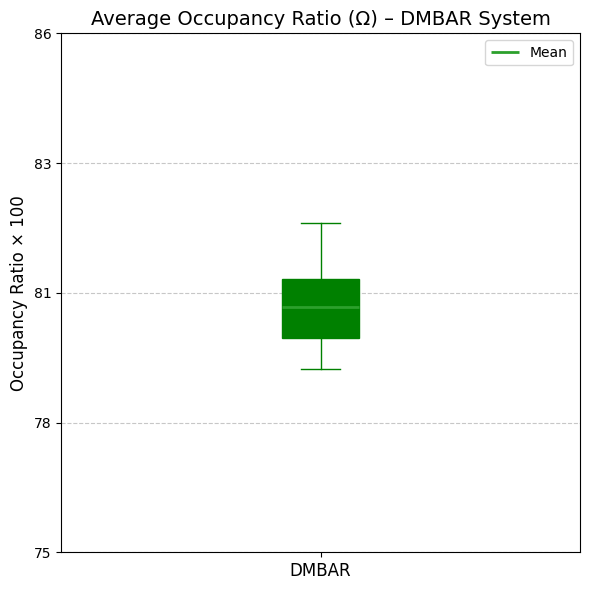

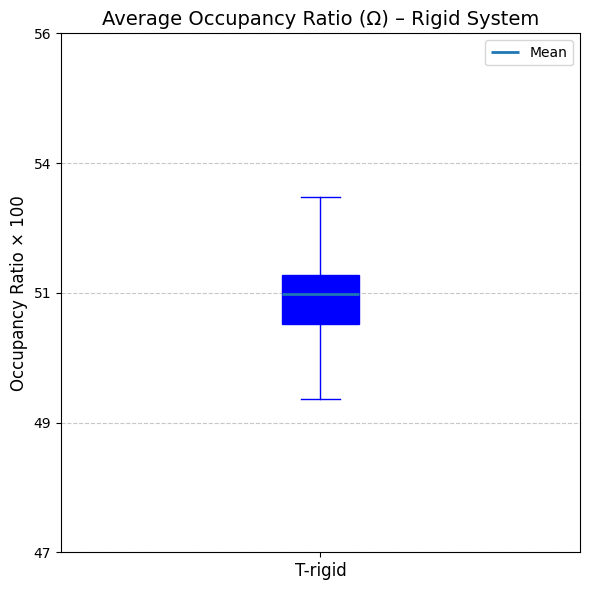

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Input Data ---
dmbar_occupancy = np.array([0.8101, 0.8207, 0.7954, 0.8156, 0.8047, 0.8031, 0.7974, 0.7892, 0.7981, 0.7933])
mrigid_occupancy = np.array([0.5091, 0.5301, 0.4975, 0.5267, 0.5110, 0.5046, 0.5177, 0.5171, 0.5143, 0.5161])

def plot_occupancy_boxplots_mean_inside(dmbar_occupancy, mrigid_occupancy):
    # --- Figure 1: DMBAR System ---
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    bp1 = ax1.boxplot(dmbar_occupancy, patch_artist=True, whis=2.0)

    # Colors
    light_green = '#b2f2bb'
    dark_green = '#2ca02c'

    # Style box
    bp1['boxes'][0].set(facecolor=light_green, color='green')
    bp1['medians'][0].set(color='green')
    for line in bp1['whiskers']: line.set(color='green')
    for line in bp1['caps']: line.set(color='green')
    for flier in bp1['fliers']: flier.set(markerfacecolor='green', marker='o')

    # Draw mean line exactly inside the box
    mean_dmbar = np.mean(dmbar_occupancy)
    box_vertices = bp1['boxes'][0].get_path().vertices
    xmin, xmax = box_vertices[:,0].min(), box_vertices[:,0].max()
    ax1.hlines(mean_dmbar, xmin=xmin, xmax=xmax, colors=dark_green, linestyles='-', linewidth=2, label='Mean')

    ax1.set_title('Average Occupancy Ratio (Ω) – DMBAR System', fontsize=14)
    ax1.set_ylabel('Occupancy Ratio × 100', fontsize=12)
    ax1.set_xticks([1])
    ax1.set_xticklabels(['DMBAR'], fontsize=12)

    ax1.set_ylim(np.min(dmbar_occupancy)*0.95, np.max(dmbar_occupancy)*1.05)
    y_ticks = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 5)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels([f'{val*100:.0f}' for val in y_ticks])

    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.legend()
    plt.tight_layout()
    plt.show()

    # --- Figure 2: Rigid System ---
    fig2, ax2 = plt.subplots(figsize=(6, 6))
    bp2 = ax2.boxplot(mrigid_occupancy, patch_artist=True, whis=2.0)

    # Colors
    light_blue = '#add8e6'
    dark_blue = '#1f77b4'

    # Style box
    bp2['boxes'][0].set(facecolor=light_blue, color='blue')
    bp2['medians'][0].set(color='blue')
    for line in bp2['whiskers']: line.set(color='blue')
    for line in bp2['caps']: line.set(color='blue')
    for flier in bp2['fliers']: flier.set(markerfacecolor='blue', marker='o')

    # Draw mean line exactly inside the box
    mean_mrigid = np.mean(mrigid_occupancy)
    box_vertices = bp2['boxes'][0].get_path().vertices
    xmin, xmax = box_vertices[:,0].min(), box_vertices[:,0].max()
    ax2.hlines(mean_mrigid, xmin=xmin, xmax=xmax, colors=dark_blue, linestyles='-', linewidth=2, label='Mean')

    ax2.set_title('Average Occupancy Ratio (Ω) – Rigid System', fontsize=14)
    ax2.set_ylabel('Occupancy Ratio × 100', fontsize=12)
    ax2.set_xticks([1])
    ax2.set_xticklabels(['T-rigid'], fontsize=12)

    ax2.set_ylim(np.min(mrigid_occupancy)*0.95, np.max(mrigid_occupancy)*1.05)
    y_ticks = np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 5)
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels([f'{val*100:.0f}' for val in y_ticks])

    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.legend()
    plt.tight_layout()
    plt.show()

# Execute
plot_occupancy_boxplots_mean_inside(dmbar_occupancy, mrigid_occupancy)
